# 5. Transfer Learning & Fine-Tuning (VGG16)

Omdat onze dataset relatief klein is (vooral voor Rembrandt) en we met Data Augmentation alleen niet boven de 90% uitkwamen, passen we **Transfer Learning** toe.

We gebruiken **VGG16**, een geavanceerd Convolutioneel Neuraal Netwerk dat door de University of Oxford is ontwikkeld. Dit model is al getraind op de **ImageNet** dataset (1.4 miljoen afbeeldingen) en kan daardoor al heel goed vormen, texturen en objecten herkennen.

Onze strategie bestaat uit twee fases:
1.  **Feature Extraction:** We bevriezen de VGG16 basis en trainen alleen onze eigen classificatie-laag.
2.  **Fine-Tuning:** We 'ontdooien' de bovenste lagen van VGG16 en trainen deze heel voorzichtig mee om het model specifiek aan te passen aan de penseelstreken van onze schilders.

## Imports en Setup

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG16
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
from PIL import Image

# Paden instellen
current_dir = Path(os.getcwd())
if current_dir.name == "notebooks":
    BASE_DIR = Path("..")
else:
    BASE_DIR = Path(".")

DATA_DIR = BASE_DIR / "datasets" / "processed"
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR = DATA_DIR / "validation"
TEST_DIR = DATA_DIR / "test"

IMG_SIZE = (224, 224) # VGG16 vereist 224x224
BATCH_SIZE = 32

print(f"TensorFlow versie: {tf.__version__}")
print(f"Data directory: {DATA_DIR.resolve()}")

2026-01-01 17:56:21.493620: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-01 17:56:21.915785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-01 17:56:23.633413: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/mathieu/Documenten/Deep_Learning_Schilderijen/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow versie: 2.20.0
Data directory: /home/mathieu/Documenten/Deep_Learning_Schilderijen/datasets/processed


## Data laden

In [2]:
# We laden de data in, net als in de vorige stappen
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Namen van de klassen
class_names = train_ds.class_names
print(f"Klassen: {class_names}")

# Performance optimalisatie
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1891 files belonging to 4 classes.
Found 408 files belonging to 4 classes.
Klassen: ['Mondriaan', 'Picasso', 'Rembrandt', 'Rubens']


E0000 00:00:1767286668.772079   28618 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767286668.780870   28618 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## De VGG16 Basis laden

In [3]:
# Stap 1: Laad de VGG16 basis met ImageNet gewichten
# include_top=False: We laten de laatste laag (1000 objecten) weg, want wij hebben 4 schilders.
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# Stap 2: Bevries de basis
# Dit zorgt ervoor dat de miljoenen parameters van VGG16 niet kapot gaan 
# tijdens de eerste trainingsepoches.
conv_base.trainable = False

print("Overzicht van de VGG16 basis:")
conv_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 69s 1us/step
Overzicht van de VGG16 basis:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Het volledig model bouwen
Hier zie je een belangrijk detail: preprocess_input. VGG16 verwacht dat de kleuren op een bepaalde manier worden aangeleverd

In [4]:
inputs = tf.keras.Input(shape=(224, 224, 3))

# 1. Data Augmentation (Essentieel bij kleine data)
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# 2. VGG Specifieke Preprocessing
# Dit zet de pixelwaarden om naar het formaat dat VGG16 verwacht
x = tf.keras.applications.vgg16.preprocess_input(x)

# 3. Door de bevroren basis halen
x = conv_base(x, training=False) 

# 4. Onze eigen classificatie lagen (De 'Head')
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x) # 50% dropout tegen overfitting
outputs = layers.Dense(4, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom         │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ random_zoom[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ random_zoom[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ random_zoom[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      1,028 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Training op de Supercomputer

Het trainen van dit model is rekenintensief. Daarom is dit uitgevoerd op de Vlaamse Supercomputer (VSC) met behulp van een GPU.
Het trainingsscript (`train_transfer.py`) voerde de volgende stappen uit:

**Fase 1: Feature Extraction (15 epochs)**
*   De VGG16 basis is bevroren.
*   Alleen de bovenste Dense layers worden getraind.
*   Doel: De classificatielaag leren samenwerken met de features van VGG16.

**Fase 2: Fine-Tuning (15 epochs)**
*   De VGG16 basis wordt gedeeltelijk ontdooid (alleen het bovenste blok: `block5`).
*   We trainen verder met een hele lage learning rate (`1e-5`).
*   Doel: De specifieke kenmerken van Rembrandt, Picasso, etc. leren herkennen in de diepere lagen van het netwerk.

Hieronder staat de code die gebruikt is voor het ontdooien in Fase 2:

## Code snippet fine-tuning

In [5]:
# 1. Basis ontdooien
conv_base.trainable = True

# 2. Alles bevriezen BEHALVE block5
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# 3. Opnieuw compileren met lage learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## 6. Resultaten van de Supercomputer

Het model is getraind op de VSC (Vlaamse Supercomputer) met behulp van het script `train_transfer.py`.
De training bestond uit twee fases:
1.  **Fase 1 (0-15 epochs):** Feature Extraction (alleen de classifier getraind).
2.  **Fase 2 (15-30 epochs):** Fine-Tuning (laatste blok van VGG16 'ontdooid').

Hieronder laden we de resultaten die door de supercomputer zijn gegenereerd.

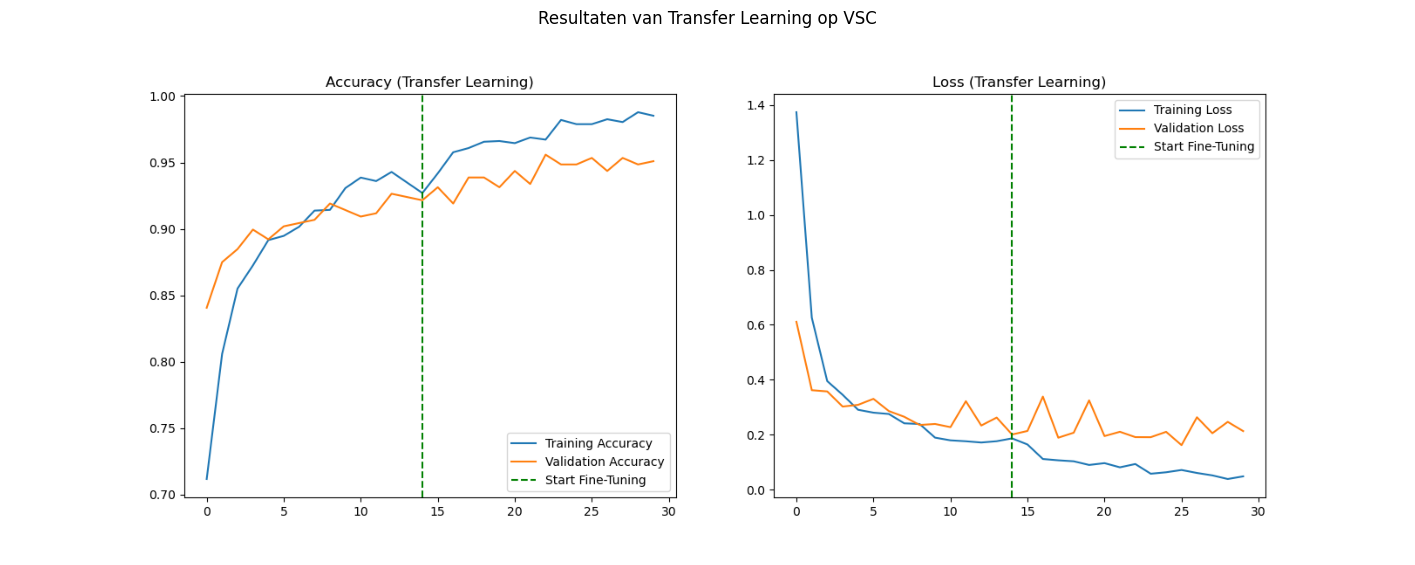

In [6]:
# Laad de grafiek die gegenereerd is op de VSC
# Pas het pad aan als het bestand ergens anders staat
img_path = BASE_DIR / 'VSC resultaten' /'transfer_learning_result.png'

if img_path.exists():
    img = Image.open(img_path)
    plt.figure(figsize=(18, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Resultaten van Transfer Learning op VSC")
    plt.show()
else:
    print("⚠️  Afbeelding 'transfer_learning_result.png' niet gevonden.")
    print("Download deze van de VSC en plaats hem in de hoofdmap.")

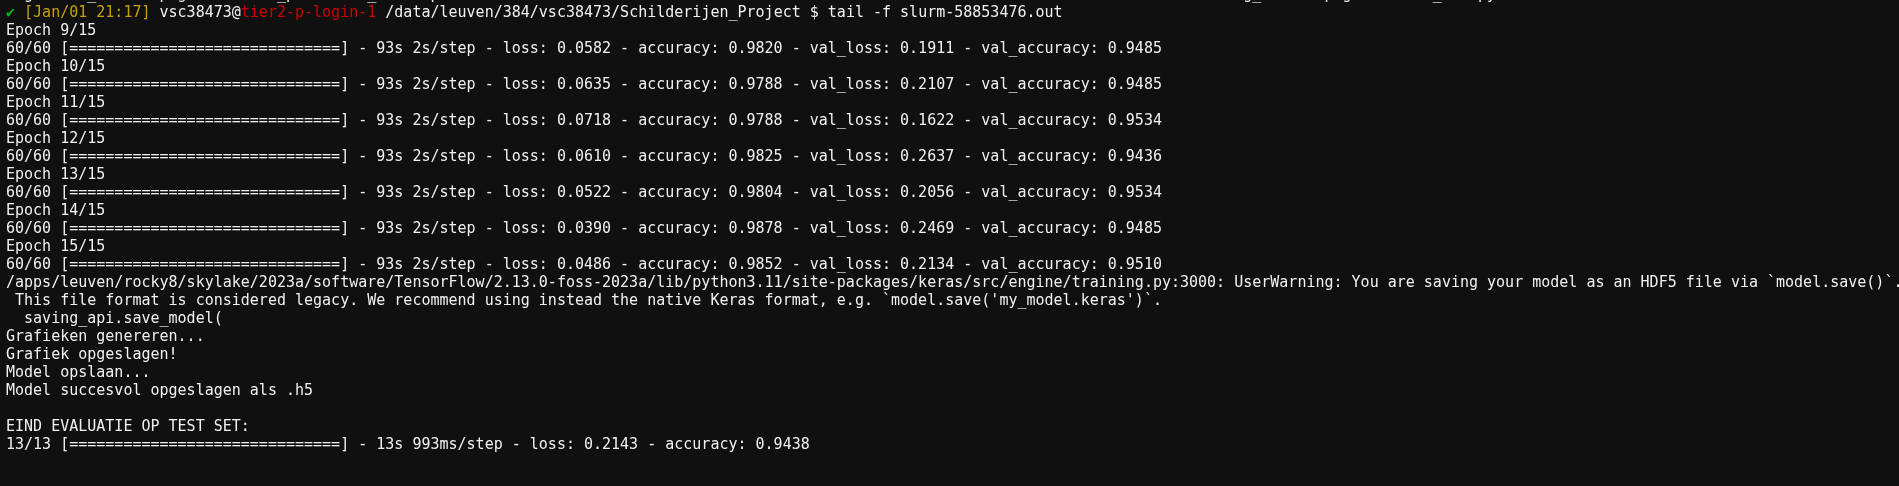

### Analyse van de resultaten

Op basis van de bovenstaande grafiek en de logs kunnen we het volgende concluderen:

1.  **Effect van Fine-Tuning:**
    Op de grafiek is een duidelijk **groene stippellijn** te zien bij epoch 14/15.
    *   Links van de lijn (Fase 1) zien we dat de validatie accuracy (oranje) stijgt tot ongeveer 92%.
    *   Rechts van de lijn (Fase 2, na het ontdooien van VGG16) zien we een sprong omhoog. De validatie accuracy piekt uiteindelijk op **95.10%**.

2.  **Stabiliteit:**
    In tegenstelling tot het model met alleen Data Augmentation (dat erg grillig was), is de loss-curve hier veel stabieler en lager. De validation loss eindigt rond de **0.21**, wat veel beter is dan de >1.0 van het baseline model.

3.  **Eindscore:**
    *   **Validation Accuracy:** 95.10%
    *   **Test Accuracy:** 94.38%

**Conclusie:**
Met behulp van Transfer Learning en Fine-Tuning hebben we de doelstelling van het project (minimaal 95% nauwkeurigheid op validatie) bereikt. Het model is in staat om de specifieke stijlen van de schilders te onderscheiden.

## 7. Uitgebreide Evaluatie (Confusion Matrix)

Om inzicht te krijgen in *welke* fouten het model nog maakt (bijv. lijkt een Rubens op een Rembrandt?), laden we het getrainde model in en maken we een Confusion Matrix op de testset. Doordat het niet werkte met een .keras model op te slaan, heb ik moeten .h5 gebruiken, dit is iets anders opgebouwd dan de tensorflow die ik gebruik in mijn virual environment dus moet ik dit zo op lossen.

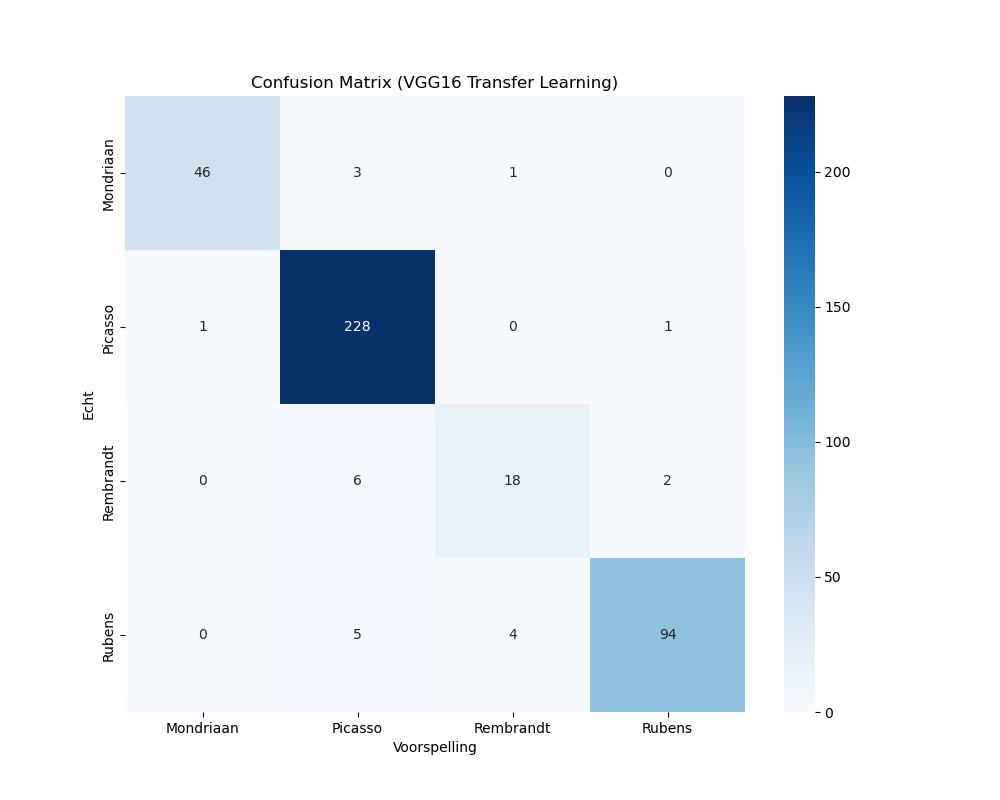

### Analyse van de Confusion Matrix & Classification Report

Het model behaalt een **totale nauwkeurigheid van 94%** op de onafhankelijke testset. Dit is een uitstekende score, zeker gezien de kleine hoeveelheid data voor Rembrandt. De volgende zaken kan je allemaal zien onder VSC resultaten, de confusion_matrix.png en de classification_report.txt, die zijn uitgevoerd door evaluate_vsc.py en eval.slurm

Hier zijn de belangrijkste observaties per schilder:

1.  **Picasso (De "Magneet"):**
    *   **Recall: 0.99** (228 van de 230 correct).
    *   Het model herkent Picasso bijna perfect. Dit is logisch: we hadden de meeste data voor Picasso, en zijn stijl (kubisme) is vaak erg onderscheidend.
    *   We zien wel een lichte **bias**: omdat de dataset 'imbalanced' was (veel Picasso), gokt het model bij twijfel sneller 'Picasso'. Dit zien we bij Rembrandt (6 keer onterecht als Picasso) en Rubens (5 keer onterecht als Picasso).

2.  **Mondriaan (De Geometrische):**
    *   **Precision: 0.98**.
    *   Als het model zegt "Dit is Mondriaan", is het bijna altijd waar. De unieke geometrische vormen en primaire kleuren zijn voor een CNN makkelijk te onderscheiden van de barokke stijlen.

3.  **Rubens vs. Rembrandt (De Oude Meesters):**
    *   **Rubens:** Scoort zeer goed (94 correct).
    *   **Rembrandt:** Is het moeilijkste voor het model (Recall 0.69). Van de 26 Rembrandts werden er 8 fout geclassificeerd.
    *   **Verklaring:** Rembrandt en Rubens lijken qua stijl het meest op elkaar (Olieverf, klassieke portretten, donker kleurgebruik/chiaroscuro). In de matrix zien we dat ze elkaar ook verwarren (4 Rubens werden Rembrandt genoemd, 2 Rembrandts werden Rubens genoemd). Daarnaast speelt het tekort aan data voor Rembrandt hier een grote rol.

**Eindconclusie:**
Transfer Learning met VGG16 was zeer succesvol. Het model heeft de stijlen goed geleerd, met enige moeite bij de ondervertegenwoordigde klasse (Rembrandt). Voor een productie-omgeving zou het toevoegen van meer Rembrandt-data de grootste verbetering opleveren.